In [1]:
from MVN import MultivariateNormal
from MCMC import MetropolisHastings, Gibbs, Cholesky, SampleSet2D
from multiple_chains import MultipleChains, errors_sampler, plot_errors
from tqdm import tqdm

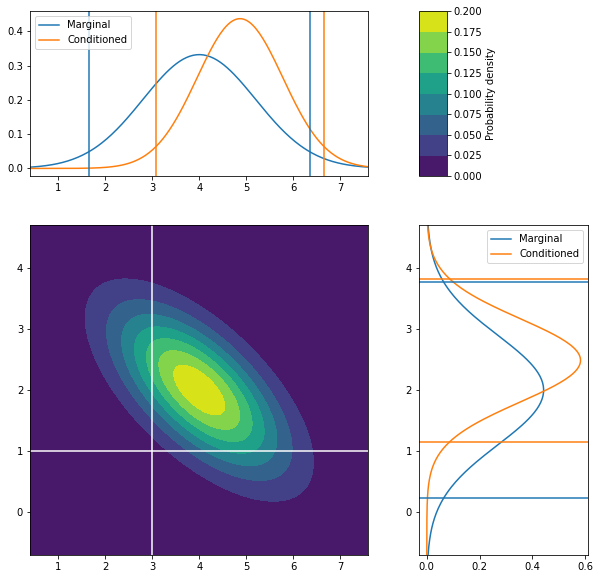

In [2]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])

CL = .95

n = MultivariateNormal(mean, covariance)
# this class, defined in a separate file, has all the properties we need

n.plot_2d_analytical(3, 1, CL)
# bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# and credible intervals for each univariate Gaussian 

In [3]:
# Let us see some numbers

mx = n.marginalize(0)
CI_x_analytical = mx.analytical_CI(CL)
my = n.marginalize(1)
CI_y_analytical = my.analytical_CI(CL)
print(f'The Credible Interval for x is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')
print(f'The Credible Interval for y is between {CI_y_analytical[0]:.2f} and {CI_y_analytical[1]:.2f}')

The Credible Interval for x is between 1.65 and 6.35
The Credible Interval for y is between 0.24 and 3.76


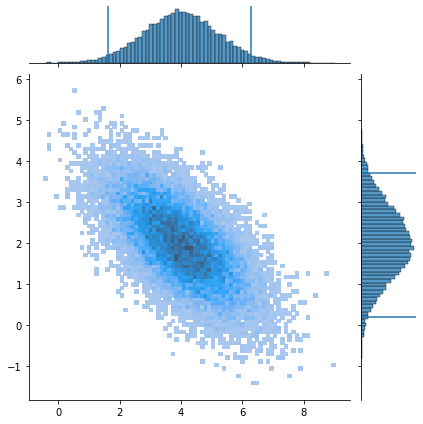

In [81]:
# CHOLESKY SAMPLING

samples_ch = SampleSet2D(n.cholesky_sample(20000))
samples_ch.samples_plot(.95, kind='hist')

In [82]:
# METROPOLIS - HASTINGS SAMPLING

# def gaussian_proposal(theta=None):
#     return (np.random.normal(scale=1, size=2))
from numpy.random import default_rng

def gaussian_proposal(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2))

num_chains = 7
spread_initial_positions = 10
initial_positions = np.random.normal(scale=spread_initial_positions, size=(num_chains, 2))

chain_length = 200

mh = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length, gaussian_proposal)

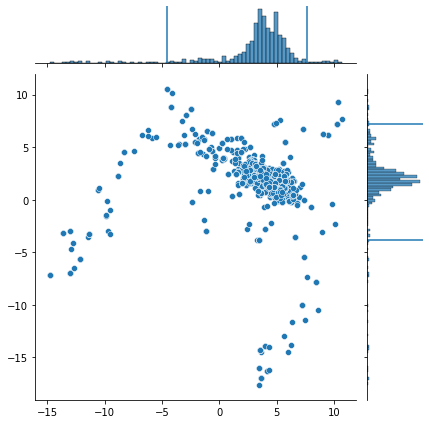

In [83]:
samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(CL, kind='scatter')

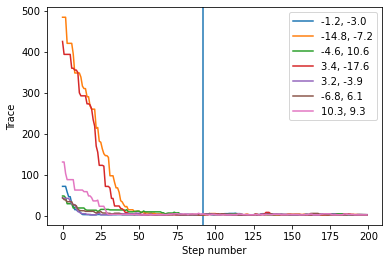

In [84]:
plt.axvline(mh.optimal_trimming)
mh.traces_plot(every=1)

In [85]:
mh.trim_chains(mh.optimal_trimming)
mh.extend_chains(int(1e4))

Trimming at 92


In [86]:
print(mh.R_estimator()) # < 1.02 in all its entries!
print(mh.autocorrelation_times()) # all close to 1! great
# am I underestimating these?

[[1.00330199 1.00515129]
 [1.00515129 1.00338013]]
[1.0006177786894122, 1.0017365298115317, 1.001049448837315, 1.0025223448277647, 1.002295987175728, 1.0010263153722834, 0.9998817048978978]


In [87]:
# SampleSet2D(mh.all_chains).samples_plot(CL, kind='kde')

In [88]:
# GIBBS SAMPLING
# from our distribution n

def conditional(i, theta):
    rng = default_rng()
    deviate = rng.standard_normal()
    
    conditioned = n.condition(i, theta[1-i])
    sigma = np.sqrt(conditioned.cov)
    return((conditioned.mean + sigma * deviate)[0,0])

g = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)


Trimming at 4


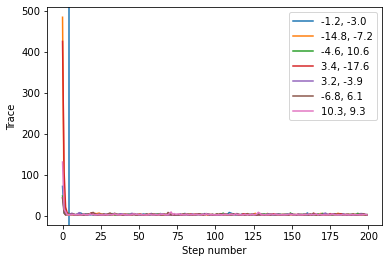

In [89]:
plt.axvline(g.optimal_trimming)
g.traces_plot(every=1)
g.trim_chains(g.optimal_trimming)

In [90]:
g.extend_chains(int(1e3))

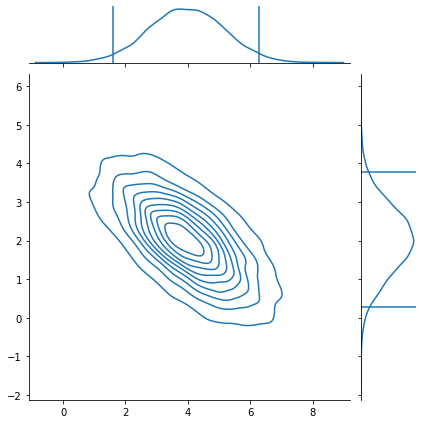

In [91]:
SampleSet2D(g.all_chains).samples_plot(CL, kind='kde')

In [92]:
chain_length = 10
rng = default_rng()

def gaussian_proposal_2(theta=None):
    return(rng.standard_normal(size=2))

n2 = MultivariateNormal([0,0], covariance)

def gaussian_proposal_3(theta=None):
    return(n2.cholesky_sample().reshape((2,)))

# n1d = MultivariateNormal([0], [[1]])
# initial_positions_1d = np.random.normal(scale=spread_initial_positions, size=(num_chains, 1))

# def gaussian_proposal_1d(theta=None):
#     return(n1d.cholesky_sample().reshape((1,)))


# mc_1 = MultipleChains(Gibbs, n.pdf, initial_positions[:5], chain_length, conditional)
mc_1 = MultipleChains(MetropolisHastings, n.pdf, initial_positions[:5], chain_length, gaussian_proposal_2)
# mc_1 = MultipleChains(Cholesky, n.pdf, initial_positions, chain_length, n.cholesky_sample)

# mc_1 = MultipleChains(MetropolisHastings, n1d.pdf, initial_positions_1d, chain_length, gaussian_proposal_1d)

# trimming_index = 50
# N, e_mean, e_cov = errors_sampler(mc_1, n, max_num=int(2e7), trimming_index=trimming_index)

In [93]:
# plot_errors(N, e_mean, e_cov, mc_1, trimming_index=trimming_index)
# plt.savefig('errors_mh_sigma_1.pdf')

In [94]:
SS = SampleSet2D(g.all_chains)
x, y, z = SS.kde()

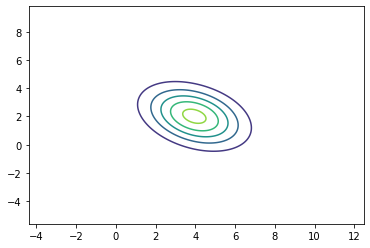

In [95]:
plt.contour(x, y, z)

In [96]:
yc, zc = SS.conditional_kde(0, 1)
cs = SS.conditional_cut(0, 1, .2)

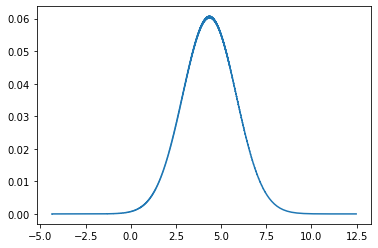

In [97]:
plt.plot(yc, zc)

(array([ 2.,  2.,  4., 12., 11., 36., 43., 39., 73., 92., 91., 75., 89.,
        68., 45., 28., 23.,  7.,  7.,  3.]),
 array([2.02358871, 2.28739772, 2.55120672, 2.81501573, 3.07882474,
        3.34263374, 3.60644275, 3.87025175, 4.13406076, 4.39786977,
        4.66167877, 4.92548778, 5.18929678, 5.45310579, 5.7169148 ,
        5.9807238 , 6.24453281, 6.50834182, 6.77215082, 7.03595983,
        7.29976883]),
 <BarContainer object of 20 artists>)

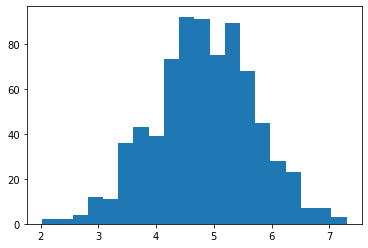

In [98]:
plt.hist(cs[:,0], bins=20)

In [99]:
cs.shape

(750, 2)

array([-0.57561286, -0.27974313])